In [135]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [136]:
names = open('names.txt', 'r').read().splitlines()

#Dictionary mapping characters to integers
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [137]:
block_size = 3 #context length
X, Y = [], [] #inputs and labels for NN
for n in names:
    context = [0] * block_size #padding for initial characters
    for ch in n + '.':
        index = stoi[ch]
        X.append(context)
        Y.append(index)
        context = context[1:] + [index] #remove and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [138]:
#build the dataset with train, validation and test sets
def build_dataset(names):
    context_size = 3
    X, Y = [], []
    for n in names:
        context = [0] * context_size
        for ch in n + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context [1:] + [ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(names)
split1 = int(0.8*len(names)) #Index of 80% of dataset
split2 = int(0.9*len(names)) #Index of 90% of dataset

#Splits
Xtr, Ytr = build_dataset(names[:split1]) #80% of dataset
Xval, Yval = build_dataset(names[split1:split2]) #Next 10% for validation
Xte, Yte = build_dataset(names[split2:]) #Last 10% for test split.                                                                                      


In [139]:
g = torch.Generator().manual_seed(2147483647)
#Lookup table for embedding
C = torch.randn((27, 10), generator=g) #2 dimensions for all 27 characters
#------------------------
#emb = C[X]
#emb.shape 
#------------------------
#C is a list of 27 vectors of size 2(embedding for each character)
#X is a grid of numbers with no of rows = no of examples and context window size columns
#We need to get embeddings so we need to index into C using X where each number in X tells you which row to pick from C
#So C[X] returns a new grid that’s the same shape as X (32 × 3), but instead of just numbers, each cell now holds a 2-value vector from C
#Hence the shape becomes (32, 3, 2)
#Example: X[13, 2] = 5 (X 13th row, 2nd column) = 5
#C[X][13, 2] = C[5] = [a1, a2]


In [140]:
#Not needed anymore
lre = torch.linspace (-3, 0, 1000) #Linearly create 1000 numbers from -3 to 1
lrs = 10**lre #Space the learning rates exponentially rather than linearly (10^-3 to 10^0)

In [141]:
lri = []
lossi = []
stepi = []

In [142]:
W1 = torch.randn((30, 200), generator=g) #30 inputs (3 ten dimensional embeddings), no of outputs = 200 neurons
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
     p.requires_grad = True

for i in range (20000):
    #minibatch: Train on batches
    batchIndexes = torch.randint(0, Xtr.shape[0], (32,)) #32 random rows from X

    #Embedding (see above)
    emb = C[Xtr[batchIndexes]]

    #Concatenate the embedding (concatenate so that each example has its 3 * 2 values in one row)
    #torch.cat(torch.unbind(emb, 1), 1) #unbind along dimension 1 and concatenate to get 32 rows of 6 values each
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #emb.view reshapes the tensor (does not need new memory) into 30 columsn and the -1 means python will infer the number of rows which is emb.shape[0]

    #Forward Pass
    logits = h @ W2 + b2

    #Old loss implementation
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)
    #loss = -prob[torch.arange(32), Y].log().mean() #For all 32 examples index the probabilities with Y to get the prob predicted of the actual answer. Then take negative log likelihood
    loss = F.cross_entropy(logits, Ytr[batchIndexes]) #More efficient (forward and backward passes) and numerically well behaved

    #Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #Update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #Track learning rate
    #lri.append(lre[i])
    #lossi.append(loss.item())
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

2.8554205894470215


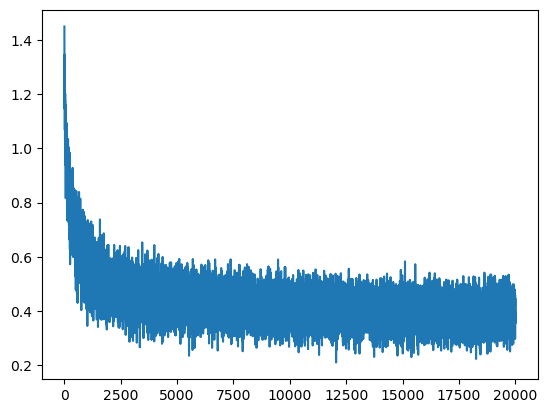

In [143]:
plt.plot(stepi, lossi)

In [144]:
#Loss on validation 
emb = C[Xval]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.4820, grad_fn=<NllLossBackward0>)

In [145]:
#Test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.4725, grad_fn=<NllLossBackward0>)

In [ ]:
#Sample from model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size #Inital context is . . .

    while True: 
      emb = C[torch.tensor([context])] #Embed context
      h = torch.tanh(emb.view(1, -1) @ W1 + b1) # First layer
      logits = h @ W2 + b2 #Second layer output logits
      probs = F.softmax(logits, dim=1) #Probabilities
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() #Sample
      context = context[1:] + [ix] #Update context
      out.append(ix)
      if ix == 0: #If ending character stop generation
        break
    
    print(''.join(itos[i] for i in out))


chrich.
amiyh.
kih.
jora.
reviy.
skany.
kena.
huna.
dppyvia.
ireei.
neamara.
chaiivia.
leigh.
ham.
pois.
quinn.
suli.
rai.
ivia.
wazelo.
